In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.figure(dpi=200)
    if title is not None:
        plt.title(title)
    npimg = np.transpose(npimg, (1,2,0))
    cmap = None
    if npimg.shape[-1] not in [3,4]:
        npimg = npimg[:,:,0]
        cmap = 'gray'
    plt.imshow(npimg, interpolation='nearest', cmap=cmap)

In [3]:
epochs = 0

# CelebA Data

In [4]:
batch_size = 128

In [5]:
from data import CelebA
dataset = CelebA(transform=transforms.Compose([
                    transforms.CenterCrop(178),
                    transforms.Grayscale(),
                    transforms.Resize((256, 256)), 
                    transforms.ToTensor()]), label='male'
                 )

In [6]:
idcs = np.arange(len(dataset))
np.random.seed(0) # This is important to split the same way every single time
np.random.shuffle(idcs)
split_idx = int(0.9 * len(dataset))
train_idcs = idcs[:split_idx]
test_idcs = idcs[split_idx:]

In [7]:
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)

### Toggle cell below for sample debugging

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, num_workers=4)

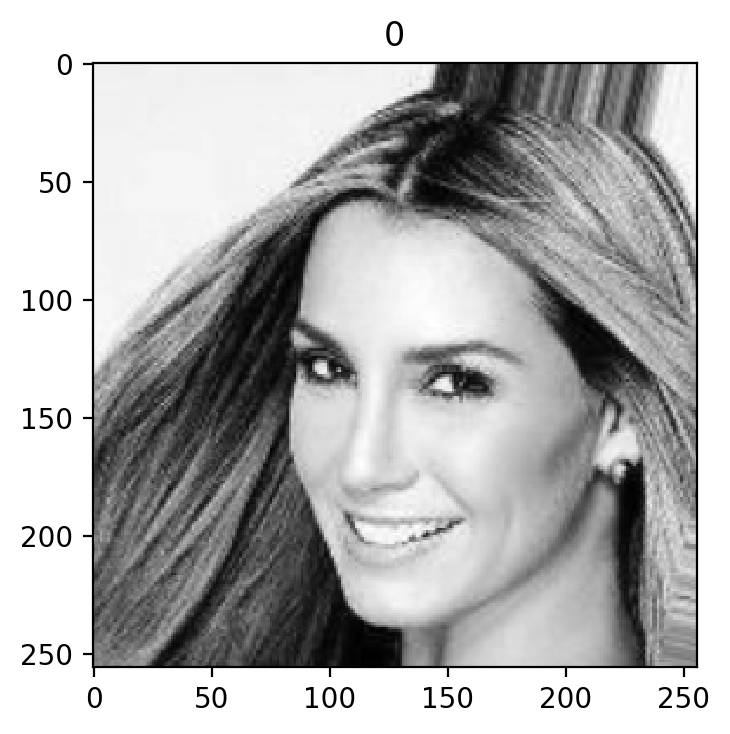

In [9]:
a_face, gender = dataset[0]
show(a_face, gender)

# VAE Model

In [10]:
from models import VAE

In [11]:
device = torch.device("cuda")

In [12]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 256, 256)[:n]])
                show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Load

In [14]:
weight_path = 'weights/{}_{}.pt'.format(model.__class__.__name__, dataset.__class__.__name__)
weight_path

'weights/VAE_CelebA.pt'

In [15]:
import os
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))    

# Train

In [16]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 50).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(epoch))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs


# Evaluate

In [17]:
model.eval()
torch.set_grad_enabled(False)

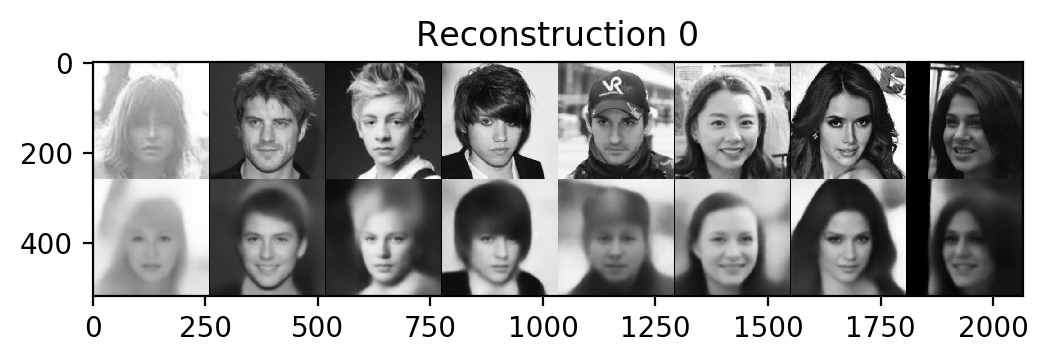

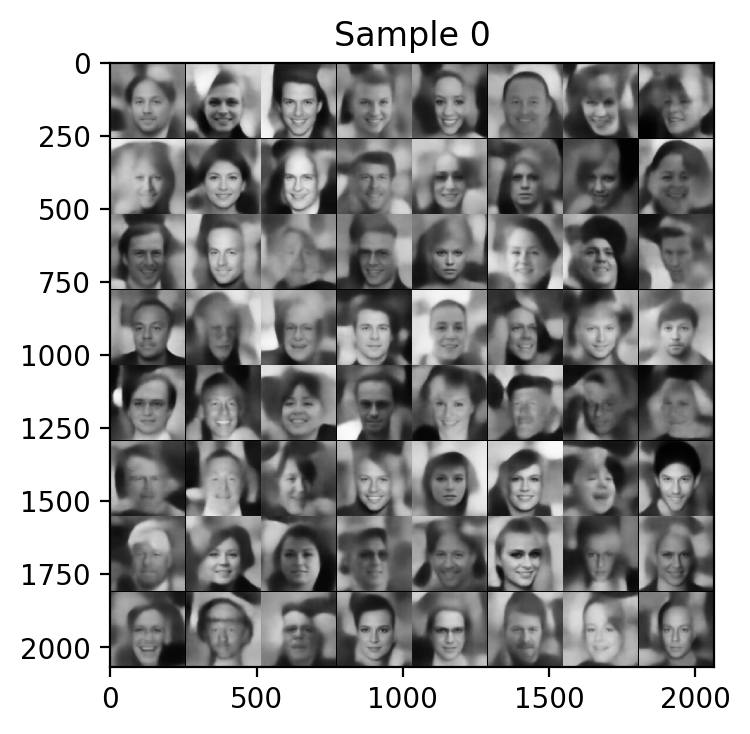

In [18]:
for data, _ in test_loader:
    data = data.to(device)
    recon_batch, mu, logvar = model(data)

    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                          recon_batch.view(batch_size, 1, 256, 256)[:n]])
    show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(0))
    break
    

sample = torch.randn(64, 50).to(device)
sample = model.decode(sample).cpu()
show(make_grid(sample.view(64, 1, 256, 256)), 'Sample {}'.format(0))

# Save

In [19]:
torch.save(model.state_dict(), weight_path)

# Transition between average male and average female

In [20]:
avg_male_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
avg_female_enc = torch.zeros(model.latent_space, dtype=torch.float).to(device)
num_male, num_female = 0, 0

In [21]:
dataset.classes

['-1', '1']

In [22]:
for faces, genders in tqdm(test_loader):
    faces = faces.to(device)
    encodes, _ = model.encode(faces)
    male_encodes = encodes[genders == 1]
    female_encodes = encodes[genders == 0]
    avg_male_enc += male_encodes.sum(dim=0)
    avg_female_enc += female_encodes.sum(dim=0)
    num_male += (genders == 1).sum()
    num_female += (genders == 0).sum()

avg_male_enc /= num_male
avg_female_enc /= num_female

100%|██████████| 159/159 [00:35<00:00,  4.52it/s]


In [23]:
num_male, num_female

(tensor(8312), tensor(11948))

In [24]:
import torchvision.utils
num_steps = 10 # num_steps = 1 -> two images
encodings = torch.empty((num_steps + 1, model.latent_space))

In [25]:
curr = avg_female_enc
step_vec = (avg_male_enc - avg_female_enc) / num_steps

In [26]:
for i in tqdm(range(num_steps + 1)):
    encodings[i] = curr
    curr += step_vec

100%|██████████| 11/11 [00:00<00:00, 2068.38it/s]


In [27]:
decoded_faces = model.decode(encodings.to(device)).cpu()

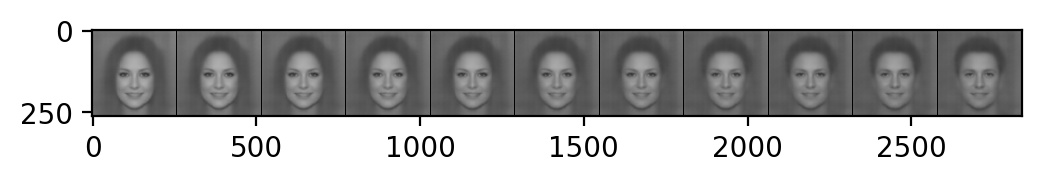

In [28]:
progressed_faces = torchvision.utils.make_grid(decoded_faces, nrow=num_steps + 1)
show(progressed_faces)

# Try it on one of our faces

/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


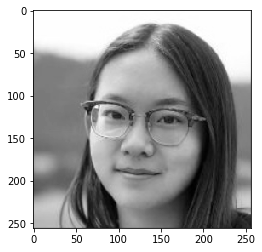

In [43]:
from skimage import io, transform
import matplotlib.pyplot as plt
my_face = np.expand_dims(transform.resize(io.imread('data/Headshots/jenny.jpg', as_grey=True), (256, 256)), -1)
plt.imshow(my_face[:,:,0], cmap='gray')

In [44]:
my_tensor = torch.from_numpy(np.expand_dims(my_face.transpose(2,0,1), 0)).float()
encodings = torch.empty((num_steps + 1, model.latent_space))
my_enc, _ = model.encode(my_tensor.to(device))

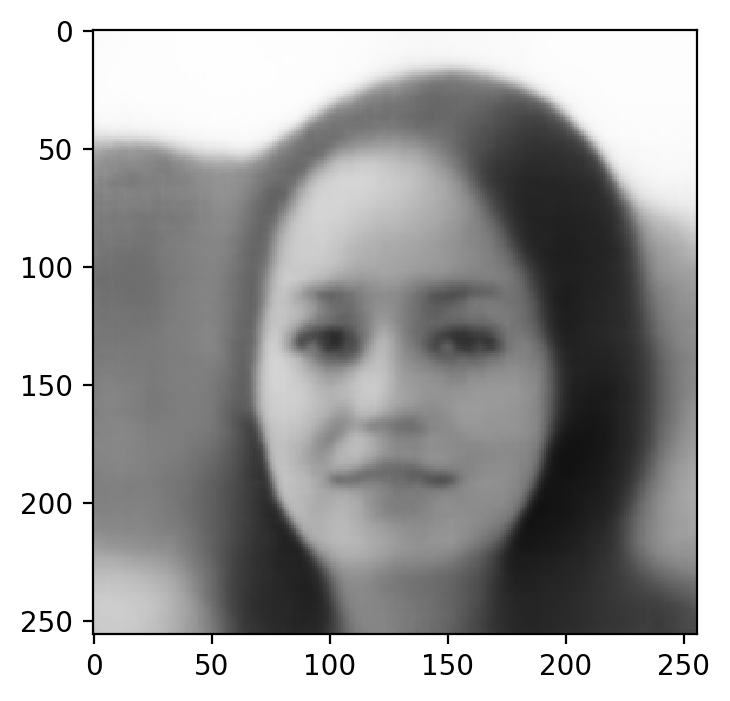

In [45]:
my_reconst, _, _ = model(my_tensor.to(device))
show(torchvision.utils.make_grid(my_reconst.cpu(), nrow=num_steps+1))

In [46]:
num_steps = 10
curr = my_enc
step_vec = ((avg_male_enc + 0.25 * my_enc) - my_enc) / num_steps

In [47]:
for i in tqdm(range(num_steps + 1)):
    encodings[i] = my_enc
    curr += step_vec

100%|██████████| 11/11 [00:00<00:00, 627.94it/s]


In [48]:
my_progression = model.decode(encodings.to(device))

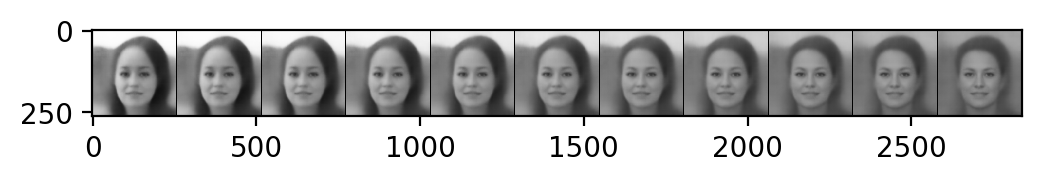

In [49]:
my_progression = torchvision.utils.make_grid(my_progression, nrow=num_steps + 1).cpu()
show(my_progression)